In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from time import time

In [13]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_lr1 = 1
best_max_depth1 = 3
best_n_estimators1 = 50

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_lr2 = 0.1
best_max_depth2 = 9
best_n_estimators2 = 150

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(columns=['round_winner'])
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_lr3 = 0.05
best_max_depth3 = 9
best_n_estimators3 = 1000

datasets = [(X1, y1, ds1_name, best_lr1, best_max_depth1, best_n_estimators1)
            ,(X2, y2, ds2_name, best_lr2, best_max_depth2, best_n_estimators2)
            ,(X3, y3, ds3_name, best_lr3, best_max_depth3, best_n_estimators3)]


Dataset: match_datawith best_lr=1, best_max_depth=3, best_n_estimators=50
Time to fit and predict: 0.35437679290771484 seconds
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       252
           1       0.60      0.66      0.63       259

    accuracy                           0.61       511
   macro avg       0.61      0.61      0.61       511
weighted avg       0.61      0.61      0.61       511

                 Predicted Negative  Predicted Positive
Actual Negative                 139                 113
Actual Positive                  87                 172
ROC AUC: 0.6587071765643195
Dataset: rounds_datawith best_lr=0.1, best_max_depth=9, best_n_estimators=150
Time to fit and predict: 68.85377860069275 seconds
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1148
           1       0.83      0.82      0.82      1190

    accuracy                           0.82      2338
   

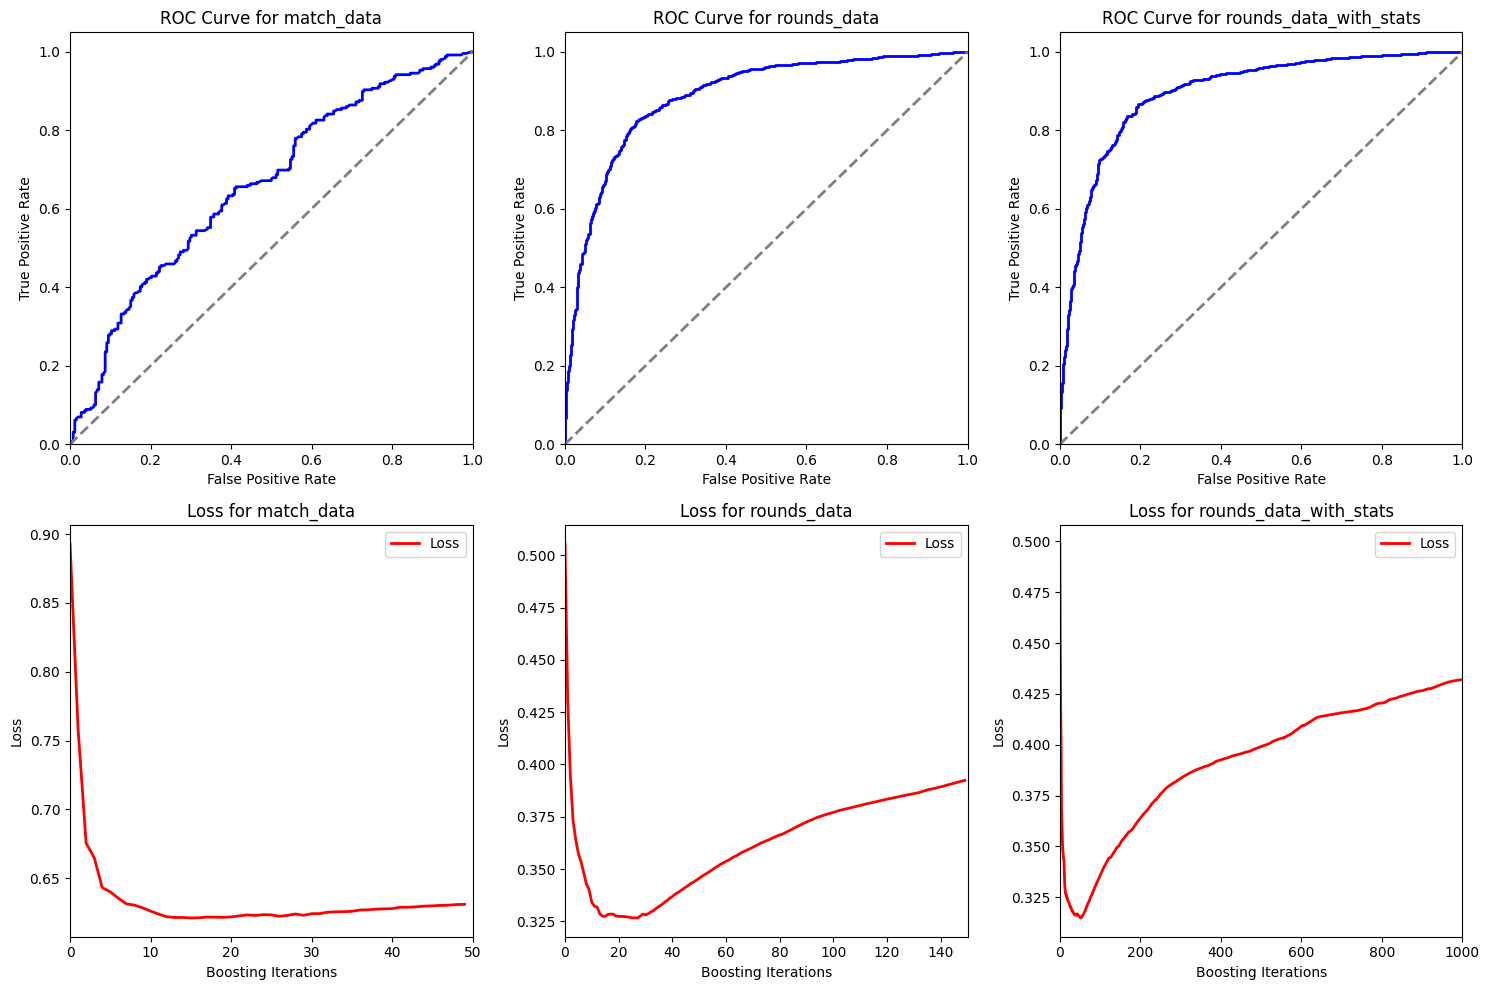

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, (X, y, ds_name, best_lr, best_max_depth, best_n_estimators) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = AdaBoostClassifier(algorithm="SAMME", n_estimators=best_n_estimators, learning_rate=best_lr, random_state=42, estimator=DecisionTreeClassifier(max_depth=best_max_depth))
    
    start_time = time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    print(f"Dataset: {ds_name}with best_lr={best_lr}, best_max_depth={best_max_depth}, best_n_estimators={best_n_estimators}")
    print(f"Time to fit and predict: {time() - start_time} seconds")
    
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:,1])}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
    
    axs[0, idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs[:,1]):.2f})')
    axs[0, idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[0, idx].set_xlim([0.0, 1.0])
    axs[0, idx].set_ylim([0.0, 1.05])
    axs[0, idx].set_xlabel('False Positive Rate')
    axs[0, idx].set_ylabel('True Positive Rate')
    axs[0, idx].set_title(f'ROC Curve for {ds_name}')

    log_losses = []
    for y_prob in model.staged_predict_proba(X_train):
        log_losses.append(log_loss(y_train, y_prob, labels=[0, 1]))

    axs[1, idx].plot(range(len(log_losses)), log_losses, color='red', lw=2, label='Loss')
    axs[1, idx].set_xlim([0, len(log_losses)])
    axs[1, idx].set_xlabel('Boosting Iterations')
    axs[1, idx].set_ylabel('Loss')
    axs[1, idx].set_title(f'Loss for {ds_name}')
    axs[1, idx].legend(loc='upper right')



plt.tight_layout()
plt.show()